In [1384]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

from hyperopt import hp, fmin, tpe, Trials

import io
import os
from PIL import Image

import json

In [1385]:
dfs_to_merge = []

## Scraped Hourly Next-Day Energy Prices

In [1386]:
df = pd.read_csv('../../data/day_ahead_energy_prices.csv', delimiter=",")[::-1]
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)
dfs_to_merge.append(df)
df

,Price
Datetime,
2024-11-21 23:00:00,107.46
2024-11-21 22:00:00,122.90
2024-11-21 21:00:00,123.05
2024-11-21 20:00:00,131.33
2024-11-21 19:00:00,154.05
...,...
2018-10-01 04:00:00,47.59
2018-10-01 03:00:00,47.38
2018-10-01 02:00:00,51.41


## Scraped Hourly Energy Mix

In [1387]:
mix_df = pd.read_csv('../../data/hourly_market_mix_cleaned.csv', delimiter=",")[::-1]
mix_df.set_index("Timestamp", inplace=True)
mix_df.index = pd.to_datetime(mix_df.index)
mix_df.rename_axis("Datetime", inplace=True) 
mix_df = mix_df.loc[:, mix_df.max() >= 0.01]
dfs_to_merge.append(mix_df)
mix_df


,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore
Datetime,,,,,,,,,,,
2024-10-30 00:00:00,0.101101,0.145455,0.045090,0.260219,0.243971,0.000000,0.049146,0.000022,0.0,0.047519,0.107476
2024-10-29 23:00:00,0.097725,0.149445,0.044872,0.274110,0.243789,0.000000,0.046156,0.000599,0.0,0.040935,0.102369
2024-10-29 22:00:00,0.095872,0.150584,0.047273,0.270704,0.255679,0.000000,0.046154,0.001140,0.0,0.035149,0.097447
2024-10-29 21:00:00,0.095560,0.150384,0.044436,0.265195,0.268427,0.000000,0.046835,0.002805,0.0,0.030024,0.096333
2024-10-29 20:00:00,0.093081,0.142999,0.047220,0.253702,0.278486,0.000000,0.044794,0.014459,0.0,0.027928,0.097331
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,0.092527,0.148990,0.019701,0.282126,0.146368,0.138012,0.040888,0.003391,0.0,0.045451,0.082545
2018-10-01 03:00:00,0.093932,0.146157,0.020071,0.286085,0.153114,0.140053,0.041441,0.003452,0.0,0.039751,0.075943
2018-10-01 02:00:00,0.094656,0.139489,0.020001,0.286402,0.161350,0.142441,0.041791,0.003471,0.0,0.038929,0.071471


## Scraped Weather Forecast Data

In [1388]:
weather_forecast_df = pd.read_csv("../../data/weather_forcast_prediciton.csv")[::-1]
weather_forecast_df.set_index("date" ,inplace=True)
weather_forecast_df.index = pd.to_datetime(weather_forecast_df.index)
weather_forecast_df.index = weather_forecast_df.index.tz_localize(None)
weather_forecast_df.rename_axis("Datetime",inplace=True)
weather_forecast_df.index = weather_forecast_df.index - pd.Timedelta(hours=24)

weather_forecast_df.rename(columns={
   "temperature_2m": "pred_temperature_2m",
   "temperature_2m_previous_day1": "pred_temperature_2m_previous_day1",
   "temperature_2m_previous_day2": "pred_temperature_2m_previous_day2",
   "temperature_2m_previous_day3": "pred_temperature_2m_previous_day3",
   "temperature_2m_previous_day4": "pred_temperature_2m_previous_day4",
   "temperature_2m_previous_day5": "pred_temperature_2m_previous_day5",
   "temperature_2m_previous_day6": "pred_temperature_2m_previous_day6",
   "temperature_2m_previous_day7": "pred_temperature_2m_previous_day7",
   "relative_humidity_2m": "pred_relative_humidity_2m",
   "relative_humidity_2m_previous_day1": "pred_relative_humidity_2m_previous_day1",
   "relative_humidity_2m_previous_day2": "pred_relative_humidity_2m_previous_day2",
   "relative_humidity_2m_previous_day3": "pred_relative_humidity_2m_previous_day3",
   "relative_humidity_2m_previous_day4": "pred_relative_humidity_2m_previous_day4",
   "relative_humidity_2m_previous_day5": "pred_relative_humidity_2m_previous_day5",
   "relative_humidity_2m_previous_day6": "pred_relative_humidity_2m_previous_day6",
   "relative_humidity_2m_previous_day7": "pred_relative_humidity_2m_previous_day7",
   "precipitation": "pred_precipitation",
   "precipitation_previous_day1": "pred_precipitation_previous_day1",
   "precipitation_previous_day2": "pred_precipitation_previous_day2",
   "precipitation_previous_day3": "pred_precipitation_previous_day3",
   "precipitation_previous_day4": "pred_precipitation_previous_day4",
   "precipitation_previous_day5": "pred_precipitation_previous_day5",
   "precipitation_previous_day6": "pred_precipitation_previous_day6",
   "precipitation_previous_day7": "pred_precipitation_previous_day7",
   "surface_pressure": "pred_surface_pressure",
   "surface_pressure_previous_day1": "pred_surface_pressure_previous_day1",
   "surface_pressure_previous_day2": "pred_surface_pressure_previous_day2",
   "surface_pressure_previous_day3": "pred_surface_pressure_previous_day3",
   "surface_pressure_previous_day4": "pred_surface_pressure_previous_day4",
   "surface_pressure_previous_day5": "pred_surface_pressure_previous_day5",
   "surface_pressure_previous_day6": "pred_surface_pressure_previous_day6",
   "surface_pressure_previous_day7": "pred_surface_pressure_previous_day7",
   "shortwave_radiation": "pred_shortwave_radiation",
   "shortwave_radiation_previous_day1": "pred_shortwave_radiation_previous_day1",
   "shortwave_radiation_previous_day2": "pred_shortwave_radiation_previous_day2",
   "shortwave_radiation_previous_day3": "pred_shortwave_radiation_previous_day3",
   "shortwave_radiation_previous_day4": "pred_shortwave_radiation_previous_day4",
   "shortwave_radiation_previous_day5": "pred_shortwave_radiation_previous_day5",
   "shortwave_radiation_previous_day6": "pred_shortwave_radiation_previous_day6",
   "shortwave_radiation_previous_day7": "pred_shortwave_radiation_previous_day7",
   "wind_speed_80m": "pred_wind_speed_80m",
   "wind_speed_80m_previous_day1": "pred_wind_speed_80m_previous_day1",
   "wind_speed_80m_previous_day2": "pred_wind_speed_80m_previous_day2",
   "wind_speed_80m_previous_day3": "pred_wind_speed_80m_previous_day3",
   "wind_speed_80m_previous_day4": "pred_wind_speed_80m_previous_day4",
   "wind_speed_80m_previous_day5": "pred_wind_speed_80m_previous_day5",
   "wind_speed_80m_previous_day6": "pred_wind_speed_80m_previous_day6",
   "wind_speed_80m_previous_day7": "pred_wind_speed_80m_previous_day7",
}, inplace=True)

# dfs_to_merge.append(weather_forecast_df)

weather_forecast_df

,pred_temperature_2m,pred_temperature_2m_previous_day1,pred_temperature_2m_previous_day2,pred_temperature_2m_previous_day3,pred_temperature_2m_previous_day4,pred_temperature_2m_previous_day5,pred_temperature_2m_previous_day6,pred_temperature_2m_previous_day7,pred_relative_humidity_2m,pred_relative_humidity_2m_previous_day1,...,pred_shortwave_radiation_previous_day6,pred_shortwave_radiation_previous_day7,pred_wind_speed_80m,pred_wind_speed_80m_previous_day1,pred_wind_speed_80m_previous_day2,pred_wind_speed_80m_previous_day3,pred_wind_speed_80m_previous_day4,pred_wind_speed_80m_previous_day5,pred_wind_speed_80m_previous_day6,pred_wind_speed_80m_previous_day7
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-10-29 22:00:00,11.490999,9.490999,11.063000,9.613,11.113000,9.090000,6.94,9.4895,97.0,100.0,...,0.0,0.0,4.610250,0.804984,5.400000,3.240000,4.379589,7.729527,5.040000,6.877790
2024-10-29 21:00:00,11.490999,9.790999,11.363000,10.013,11.363000,9.290000,7.24,9.8395,97.0,99.0,...,0.0,0.0,6.151683,1.484318,5.860375,2.414954,3.075841,7.244860,4.680000,8.350138
2024-10-29 20:00:00,11.490999,9.591000,11.613000,10.263,11.863000,9.440001,7.54,10.1895,96.0,100.0,...,0.0,0.0,4.104631,1.484318,8.891343,4.334974,3.219938,6.924738,3.319036,12.144331
2024-10-29 19:00:00,11.990999,10.091000,12.063000,10.563,12.513000,9.640000,7.84,10.5895,94.0,100.0,...,0.0,0.0,3.415260,2.968636,8.209263,5.154416,3.877318,6.489992,2.276840,17.026896
2024-10-29 18:00:00,12.441000,11.040999,12.662999,10.813,13.212999,9.990001,8.24,11.2895,92.0,96.0,...,0.0,0.0,5.483357,5.506941,5.904439,0.804984,4.680000,6.489992,2.968636,20.345573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-04 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Scraped Actual Weather Data

In [1389]:
daily_weather_df = pd.read_csv('../../data/daily_weather.csv', delimiter=",")

daily_weather_df.set_index('date', inplace=True)
daily_weather_df.index = pd.to_datetime(daily_weather_df.index)

daily_weather_df.index = daily_weather_df.index.tz_localize(None)

daily_weather_df.rename(columns={
    'Precipitation (rain/snow)': 'precipitation',
    'wind_speed_100m': 'wind_speed_100m',
    'Global Horizontal Irradiance': 'shortwave_radiation',
    'direct_radiation': 'direct_radiation', 
    }, inplace=True)

dfs_to_merge.append(daily_weather_df)
daily_weather_df


,temperature_2m,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,wind_speed_100m,sunshine_duration,shortwave_radiation,direct_radiation
date,,,,,,,,,
2018-01-01 00:00:00,10.007,72.08582,0.1,962.85810,100.0,44.946686,0.0,0.0,0.0
2018-01-01 01:00:00,9.107,78.18726,0.5,963.12980,99.0,36.797560,0.0,0.0,0.0
2018-01-01 02:00:00,8.057,86.00295,0.8,963.38170,97.0,33.895490,0.0,0.0,0.0
2018-01-01 03:00:00,7.357,88.34976,1.2,963.87006,100.0,36.589180,0.0,0.0,0.0
2018-01-01 04:00:00,7.007,83.81951,0.4,964.30660,95.0,37.842830,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-11-21 19:00:00,-2.243,78.99428,0.0,955.57263,100.0,25.283434,0.0,0.0,0.0
2024-11-21 20:00:00,-2.343,79.58027,0.0,955.65520,100.0,25.821060,0.0,0.0,0.0
2024-11-21 21:00:00,-1.293,74.78562,0.0,955.79816,100.0,25.837994,0.0,0.0,0.0


## Merged Data

In [1390]:
merged_df = pd.concat(dfs_to_merge, axis=1, join='inner') # TODO: describe merge
merged_df.index

DatetimeIndex(['2024-10-30 00:00:00', '2024-10-29 23:00:00',
               '2024-10-29 22:00:00', '2024-10-29 21:00:00',
               '2024-10-29 20:00:00', '2024-10-29 19:00:00',
               '2024-10-29 18:00:00', '2024-10-29 17:00:00',
               '2024-10-29 16:00:00', '2024-10-29 15:00:00',
               ...
               '2018-10-01 09:00:00', '2018-10-01 08:00:00',
               '2018-10-01 07:00:00', '2018-10-01 06:00:00',
               '2018-10-01 05:00:00', '2018-10-01 04:00:00',
               '2018-10-01 03:00:00', '2018-10-01 02:00:00',
               '2018-10-01 01:00:00', '2018-10-01 00:00:00'],
              dtype='datetime64[ns]', length=53161, freq=None)

## Test/Evaluation/Train Set Split

In [1391]:
TEST_SIZE = 0.18

SPLIT_DATE_EVAL = merged_df.index[int(TEST_SIZE * len(merged_df))]


train = merged_df.loc[merged_df.index < SPLIT_DATE_EVAL]
initial_test = merged_df.loc[merged_df.index >= SPLIT_DATE_EVAL]


test_eval_split = int(len(initial_test) / 2)

SPLIT_DATE_TEST = merged_df.index[int(TEST_SIZE * len(merged_df)) - test_eval_split - 1]

test = initial_test.iloc[:test_eval_split]
eval = initial_test.iloc[test_eval_split:]

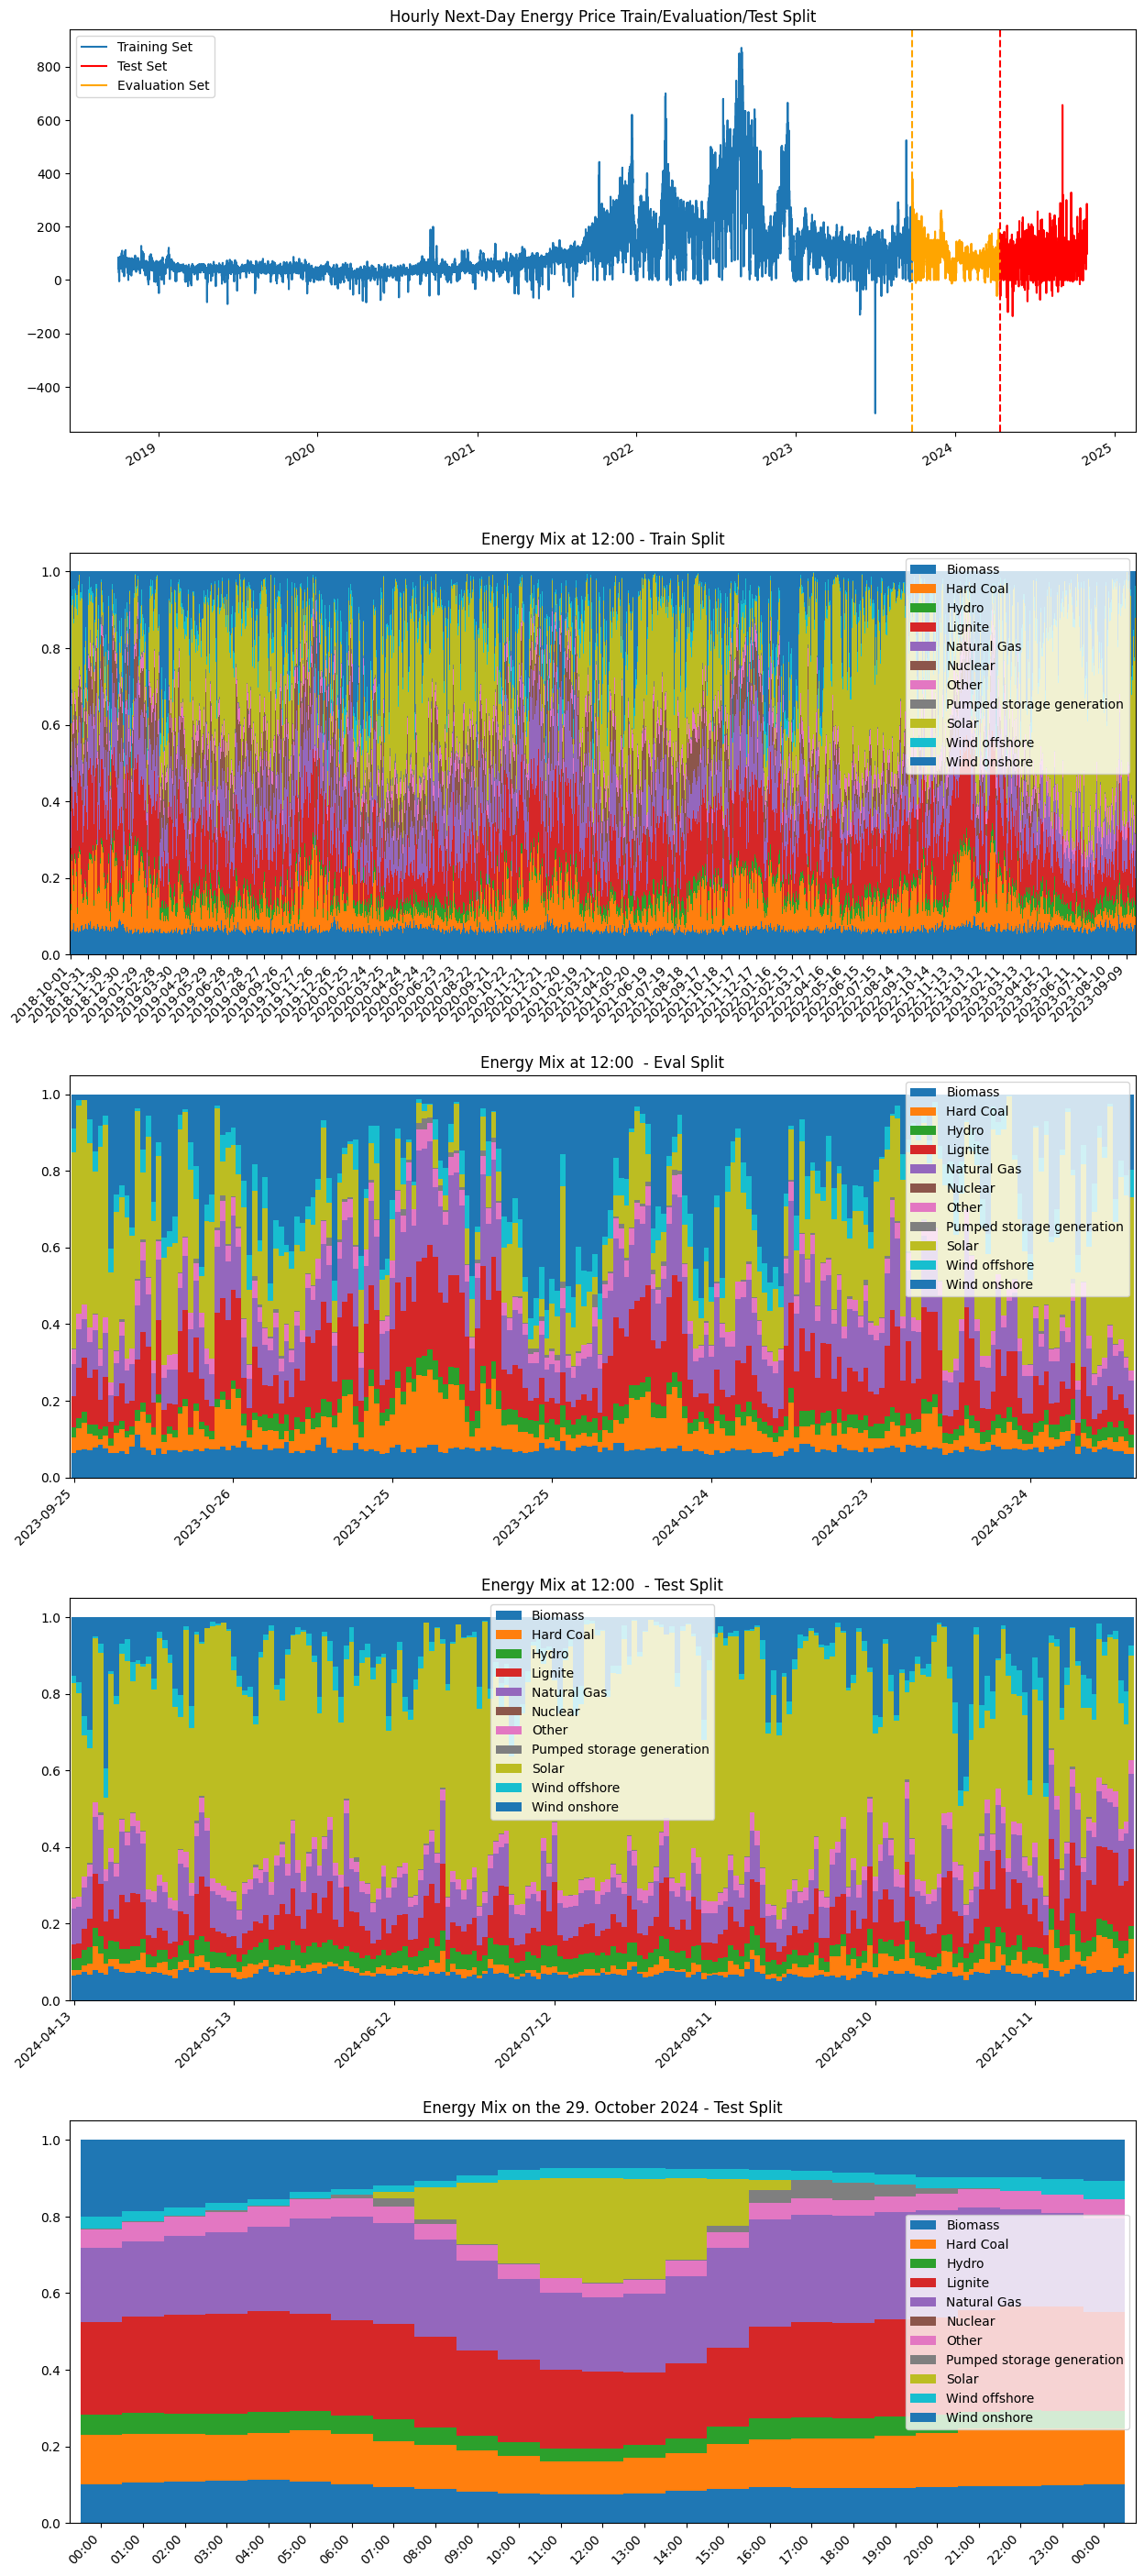

In [1392]:
fig, axs = plt.subplots(nrows=5, figsize=(15, 40))
train["Price"].plot(ax=axs[0], label='Training Set', title='Hourly Next-Day Energy Price Train/Evaluation/Test Split')
test["Price"].plot(ax=axs[0], label='Test Set', color="red")
eval["Price"].plot(ax=axs[0], label='Evaluation Set', color="orange")
axs[0].axvline(SPLIT_DATE_EVAL, color='orange', ls='--')
axs[0].axvline(SPLIT_DATE_TEST, color='red', ls='--')
axs[0].legend(['Training Set', 'Test Set', 'Evaluation Set'])


cols = [
    "Biomass",
    "Hard Coal",
    "Hydro",
    "Lignite",
    "Natural Gas",
    "Nuclear",
    "Other",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore"
    ]

filtered_train = train[train.index.hour == 12][::-1]
filtered_train[cols].plot(ax=axs[1], kind="bar", stacked=True, title='Energy Mix at 12:00 - Train Split', width=1.0)
axs[1].set_xticks(np.arange(0, len(filtered_train), 30))
axs[1].set_xticklabels(filtered_train.index[::30].strftime('%Y-%m-%d'), rotation=45, ha='right')

filtered_eval = eval[eval.index.hour == 12][::-1]
filtered_eval[cols].plot(ax=axs[2], kind="bar", stacked=True, title='Energy Mix at 12:00  - Eval Split', width=1.0)
axs[2].set_xticks(np.arange(0, len(filtered_eval), 30))
axs[2].set_xticklabels(filtered_eval.index[::30].strftime('%Y-%m-%d'), rotation=45, ha='right')

filtered_test = test[test.index.hour == 12][::-1]
filtered_test[cols].plot(ax=axs[3], kind="bar", stacked=True, title='Energy Mix at 12:00  - Test Split', width=1.0)
axs[3].set_xticks(np.arange(0, len(filtered_test), 30))
axs[3].set_xticklabels(filtered_test.index[::30].strftime('%Y-%m-%d'), rotation=45, ha='right')

filtered_test = test.head(25)[::-1]
# print(filtered_test)
filtered_test[cols].plot(ax=axs[4], kind="bar", stacked=True, title='Energy Mix on the 29. October 2024 - Test Split', width=1.0)
axs[4].set_xticks(np.arange(0, len(filtered_test), 1))
axs[4].set_xticklabels(filtered_test.index.strftime('%H:%M'), rotation=45, ha='right')

plt.subplots_adjust(hspace=0.3)
plt.show()


## Feature Selection

In [1393]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window)}_hours'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window)}_hours'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window)}_hours'] = df['Hard Coal'].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window / 24)}_days'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window / 24)}_days'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window / 24)}_days'] = df['Hard Coal'].rolling(window=window).mean()

    return df

In [1394]:
train = create_features(train)
test = create_features(test)
eval = create_features(eval)

FEATURES = [
    "hour",
    "dayofyear",
    "dayofweek",

    "ma_3_hours",
    "ma_6_hours",   
    "ma_1_days",
    # "ma_3_days",
    "ma_7_days",

# -- Energy Mix --
    "Biomass",
    "Hard Coal",
    "Hydro",
    "Lignite",
    "Natural Gas",
    "Nuclear",
    "Other",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore",

    # "biomass_ma_3_hours",
    # "biomass_ma_6_hours",
    # "biomass_ma_1_days",
    # "biomass_ma_3_days",
    # "biomass_ma_7_days",

    "pumped_storage_generation_ma_3_hours",
    "pumped_storage_generation_ma_6_hours",
    # "pumped_storage_generation_ma_1_days",
    # "pumped_storage_generation_ma_3_days",
    # "pumped_storage_generation_ma_7_days",
   
    # "hard_coal_ma_3_hours",
    # "hard_coal_ma_6_hours",
    # "hard_coal_ma_1_days",
    # "hard_coal_ma_3_days",
    # "hard_coal_ma_7_days",


#  -- Actual Weather -- 
    # "pred_temperature_2m",
    # "pred_temperature_2m_previous_day1",
    # "pred_temperature_2m_previous_day2",
    # "pred_temperature_2m_previous_day3",
    # "pred_temperature_2m_previous_day4",
    # "pred_temperature_2m_previous_day5",
    # "pred_temperature_2m_previous_day6",
    # "pred_temperature_2m_previous_day7",
    # "pred_relative_humidity_2m",
    # "pred_relative_humidity_2m_previous_day1",
    # "pred_relative_humidity_2m_previous_day2",
    # "pred_relative_humidity_2m_previous_day3",
    # "pred_relative_humidity_2m_previous_day4",
    # "pred_relative_humidity_2m_previous_day5",
    # "pred_relative_humidity_2m_previous_day6",
    # "pred_relative_humidity_2m_previous_day7",
    # "pred_precipitation",
    # "pred_precipitation_previous_day1",
    # "pred_precipitation_previous_day2",
    # "pred_precipitation_previous_day3",
    # "pred_precipitation_previous_day4",
    # "pred_precipitation_previous_day5",
    # "pred_precipitation_previous_day6",
    # "pred_precipitation_previous_day7",
    # "pred_surface_pressure",
    # "pred_surface_pressure_previous_day1",
    # "pred_surface_pressure_previous_day2",
    # "pred_surface_pressure_previous_day3",
    # "pred_surface_pressure_previous_day4",
    # "pred_surface_pressure_previous_day5",
    # "pred_surface_pressure_previous_day7",
    # "pred_shortwave_radiation",
    # "pred_shortwave_radiation_previous_day1",
    # "pred_shortwave_radiation_previous_day2",
    # "pred_shortwave_radiation_previous_day3",
    # "pred_shortwave_radiation_previous_day4",
    # "pred_shortwave_radiation_previous_day5",
    # "pred_shortwave_radiation_previous_day6",
    # "pred_shortwave_radiation_previous_day7",
    # "pred_wind_speed_80m",
    # "pred_wind_speed_80m_previous_day1",
    # "pred_wind_speed_80m_previous_day2",
    # "pred_wind_speed_80m_previous_day3",
    # "pred_wind_speed_80m_previous_day4",
    # "pred_wind_speed_80m_previous_day5",
    # "pred_wind_speed_80m_previous_day6",
    # "pred_wind_speed_80m_previous_day7",

 #  -- Actual Weather -- 
    # "temperature_2m",
    # "relative_humidity_2m",
    # "precipitation",
    # "surface_pressure",
    # "cloud_cover",
    # "wind_speed_100m",
    # "sunshine_duration",
    # "shortwave_radiation",
    # "direct_radiation",
]

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

## Auto ML

In [1395]:
default_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 13,
    "max_depth": 40,
    "learning_rate": 0.06,
    "n_estimators": 140,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
    "colsample_bylevel": 1.0,
    "colsample_bynode": 1.0,
    "reg_lambda": 1
}

In [1396]:
def model_fit_and_predict(params):
    reg = xgb.XGBRegressor(**params)

    reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=None)
    pred = reg.predict(X_test)
    score = root_mean_squared_error(y_test, pred)
    return score

def objective(search_space):

    params = {
        "base_score":search_space.get("base_score", default_params["base_score"]),
        "early_stopping_rounds":search_space.get("early_stopping_rounds", default_params["early_stopping_rounds"]), 
        "max_depth":search_space.get("max_depth", default_params["max_depth"]),
        "learning_rate":search_space.get("learning_rate", default_params["learning_rate"]),
        "n_estimators":search_space.get("n_estimators", default_params["n_estimators"]),
        "gamma":search_space.get("gamma", default_params["gamma"]),
        "min_child_weight":search_space.get("min_child_weight", default_params["min_child_weight"]),
        "subsample":search_space.get("learning_rate", default_params["learning_rate"]),
        "colsample_bytree":search_space.get("colsample_bytree", default_params["colsample_bytree"]),
        "colsample_bynode":search_space.get("colsample_bynode", default_params["colsample_bynode"]),
        "colsample_bylevel":search_space.get("colsample_bylevel", default_params["colsample_bylevel"]),
        "reg_lambda":search_space.get("learning_rate", default_params["learning_rate"]),
        # "eval_metric":'rmse',
        # "objective":'reg:squarederror',
    }

    rmse = model_fit_and_predict(params)
    
    return rmse

In [1397]:
search = False

search_space = {
    # "base_score": hp.uniform("base_score", 0.38, 0.381),
    # "early_stopping_rounds": hp.choice("early_stopping_rounds", np.arange(3, 300, 1, dtype=int)),
    "max_depth": hp.choice("max_depth", np.arange(30, 50, 1, dtype=int)),
    # "learning_rate": hp.uniform("learning_rate", 0.025, 0.035),
    # "gamma": hp.uniform("gamma", 0.9, 0.9059588489958413),
    # "reg_lambda": hp.uniform("reg_lambda", 0.98, 1),
    # "colsample_bytree": hp.uniform("colsample_bytree", 0.85, 0.90),
    # "colsample_bynode": hp.uniform("colsample_bynode", 0.5, 1),
    # "colsample_bylevel": hp.uniform("colsample_bylevel", 0.5, 1),
    # "n_estimators": hp.choice("n_estimators", np.arange(100, 1000, 10, dtype="int")),
    # "min_child_weight": hp.choice("min_child_weight", np.arange(1, 10, 1, dtype="int")),
    # "subsample": hp.uniform("subsample", 0.5712784309398466, 0.572),
}

# Keeping track of the optimization history
trials = Trials()
best_search = {}
if search:

    # Run the Hyperopt optimization
    best_search = fmin(
        fn=objective, 
        space=search_space, 
        algo=tpe.suggest,
        max_evals=20, 
        trials=trials
    )

    score = model_fit_and_predict(best_search)
    print(f'RMSE Score on Test set: {score:.2f}\n')

print(f"base_score: {best_search.get("base_score", f"{default_params["base_score"]} (user default)")}, model default: 0.5")
print(f"early_stopping_rounds: {best_search.get("early_stopping_rounds", f"{default_params["early_stopping_rounds"]} (user default)")}, model default: 10")
print(f"max_depth: {best_search.get("max_depth", f"{default_params["max_depth"]} (user default)")}, model default: 6")
print(f"learning_rate: {best_search.get("learning_rate", f"{default_params["learning_rate"]} (user default)")}, model default: 0.3")
print(f"n_estimators: {best_search.get("n_estimators", f"{default_params["n_estimators"]} (user default)")}, model default: 100")
print(f"gamma: {best_search.get("gamma", f"{default_params["gamma"]} (user default)")}, model default: 0")
print(f"min_child_weight: {best_search.get("min_child_weight", f"{default_params["min_child_weight"]} (user default)")}, model default: 1")
print(f"subsample: {best_search.get("subsample", f"{default_params["subsample"]} (user default)")}, model default: 1")
print(f"colsample_bytree: {best_search.get("colsample_bytree", f"{default_params["colsample_bytree"]} (user default)")}, model default: 1")
print(f"colsample_bynode: {best_search.get("colsample_bynode", f"{default_params["colsample_bynode"]} (user default)")}, model default: 1")
print(f"colsample_bylevel: {best_search.get("colsample_bylevel", f"{default_params["colsample_bylevel"]} (user default)")}, model default: 1")
print(f"reg_lambda: {best_search.get("reg_lambda", f"{default_params["reg_lambda"]} (user default)")}, model default: 1")
  

base_score: 0.380924762889507 (user default), model default: 0.5
early_stopping_rounds: 13 (user default), model default: 10
max_depth: 40 (user default), model default: 6
learning_rate: 0.06 (user default), model default: 0.3
n_estimators: 140 (user default), model default: 100
gamma: 0.9 (user default), model default: 0
min_child_weight: 6 (user default), model default: 1
subsample: 0.5719023844219375 (user default), model default: 1
colsample_bytree: 0.8815691043681952 (user default), model default: 1
colsample_bynode: 1.0 (user default), model default: 1
colsample_bylevel: 1.0 (user default), model default: 1
reg_lambda: 1 (user default), model default: 1


## Final Model

In [1398]:
best_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 13,
    "max_depth": 40,
    "learning_rate": 0.06,
    "n_estimators": 140,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
    "colsample_bylevel": 1.0,
    "colsample_bynode": 1.0,
    "reg_lambda": 1
}

reg = xgb.XGBRegressor(**best_params)

reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=25)

test['prediction'] = reg.predict(X_test)
score = root_mean_squared_error(y_test, test['prediction'])
print(f'RMSE Score on Test set: {score:.6f}')

[0]	validation_0-rmse:79.53822
[25]	validation_0-rmse:19.06070
[50]	validation_0-rmse:8.53247
[75]	validation_0-rmse:7.42376
[100]	validation_0-rmse:7.31702
[125]	validation_0-rmse:7.27040
[139]	validation_0-rmse:7.27134
RMSE Score on Test set: 10.507079


### Results

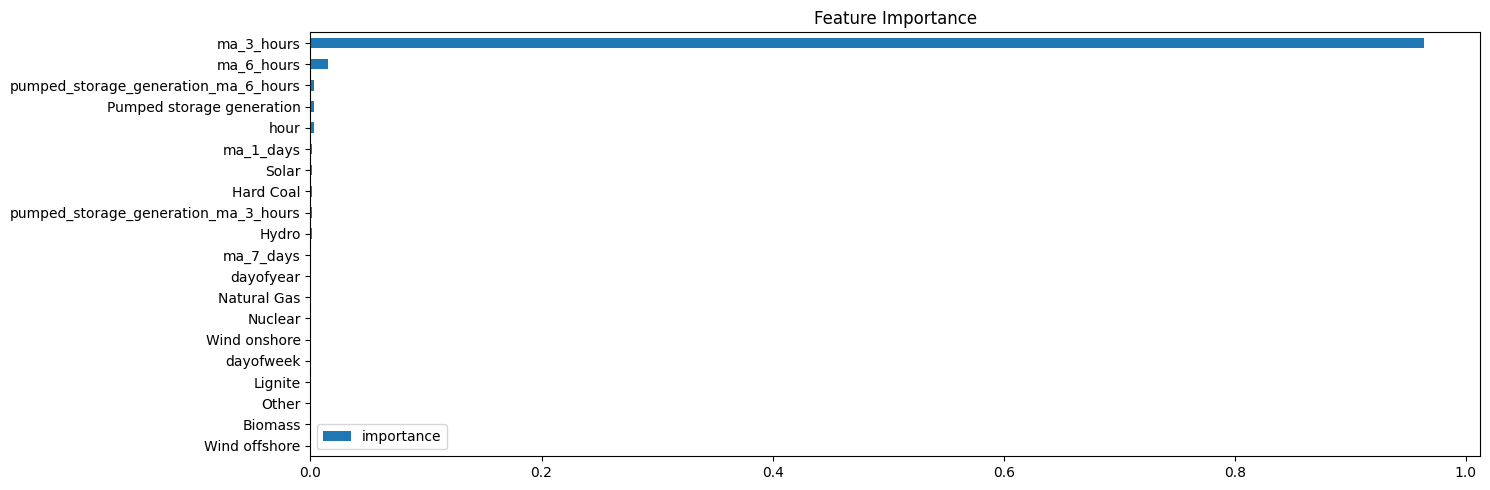

In [1399]:
idx_limited = np.argsort(reg.feature_importances_)[::-1]
fi_sorted_limited = reg.feature_importances_[idx_limited]
fn_sorted_limited = reg.feature_names_in_[idx_limited]

fi = pd.DataFrame(data=fi_sorted_limited,
             index=fn_sorted_limited,
             columns=['importance'], )
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(15, 5))
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.show()
plt.close()
buf.seek(0)

feature_importance_image = Image.open(buf)

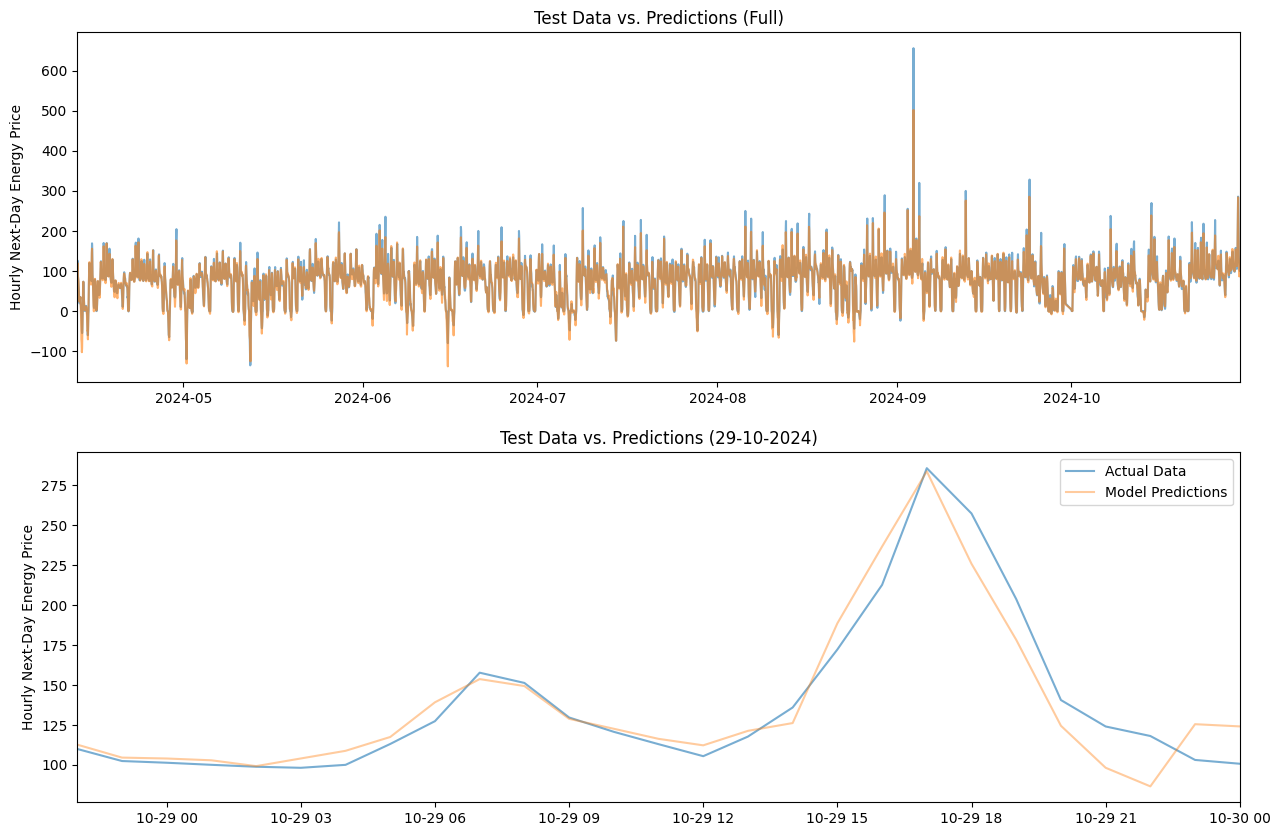

In [1400]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 10))

WINDOW = test.copy()


axs[0].plot(WINDOW.index, WINDOW[TARGET],  alpha=0.6)
axs[0].plot(WINDOW.index, WINDOW["prediction"],  alpha=0.6)
axs[0].set_xlim(WINDOW.index.min(), WINDOW.index.max())
axs[0].set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
axs[0].set_title('Test Data vs. Predictions (Full)')

WINDOW = test["2024-10-28 22:00:00":].copy()
axs[1].plot(WINDOW.index, WINDOW[TARGET],  alpha=0.6)
axs[1].plot(WINDOW.index, WINDOW["prediction"],  alpha=0.4)
axs[1].set_xlim(WINDOW.index.min(), WINDOW.index.max())
axs[1].set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
axs[1].set_title('Test Data vs. Predictions (29-10-2024)')

buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.show()
plt.close()
buf.seek(0)

ts_image = Image.open(buf)

### Specific Date Predictions

In [1401]:
date = '2024-10-29'
predictions = test.loc[date, 'prediction']

# Display the result
print(predictions)

2024-10-29 23:00:00    125.485367
2024-10-29 22:00:00     86.542801
2024-10-29 21:00:00     98.191833
2024-10-29 20:00:00    124.497467
2024-10-29 19:00:00    178.323578
2024-10-29 18:00:00    225.918320
2024-10-29 17:00:00    283.820038
2024-10-29 16:00:00    236.736557
2024-10-29 15:00:00    188.656174
2024-10-29 14:00:00    126.188988
2024-10-29 13:00:00    121.311821
2024-10-29 12:00:00    112.241791
2024-10-29 11:00:00    116.306458
2024-10-29 10:00:00    122.615532
2024-10-29 09:00:00    128.836273
2024-10-29 08:00:00    149.363586
2024-10-29 07:00:00    153.725525
2024-10-29 06:00:00    139.203918
2024-10-29 05:00:00    117.474785
2024-10-29 04:00:00    108.807159
2024-10-29 03:00:00    104.018669
2024-10-29 02:00:00     99.217125
2024-10-29 01:00:00    102.867241
2024-10-29 00:00:00    103.992012
Name: prediction, dtype: float32


### Average absolute error by day

In [1402]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test['error'].groupby(test['date']).mean()

date
2024-04-12     9.656317
2024-04-13    14.698367
2024-04-14     5.591346
2024-04-15     8.287777
2024-04-16     4.985970
                ...    
2024-10-26     6.124106
2024-10-27     6.221032
2024-10-28     5.203847
2024-10-29    11.008175
2024-10-30    23.387542
Name: error, Length: 202, dtype: float64

## Persisting Current Model and Features

In [1403]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f'./pickle/model_{score: .7g}_rmse_{ts}'
os.makedirs(output_dir, exist_ok=True)

model_dump_path = os.path.join(output_dir, "model.pickle")
with open(model_dump_path, "wb") as file:
    pickle.dump(reg, file)
hp_path = os.path.join(output_dir, "hyperparams.json")
with open(hp_path, "w") as file:
    best_params_native = {k: (int(v) if isinstance(v, (np.integer, int)) else float(v) if isinstance(v, (np.floating, float)) else v) for k, v in best_params.items()}
    json.dump(best_params_native, file, indent=4)
output_filename = 'plot_image.png'
ts_chart_path = os.path.join(output_dir, output_filename)
ts_image.save(ts_chart_path)

output_filename = 'feature_importance.png'
fi_path = os.path.join(output_dir, output_filename)
feature_importance_image.save(fi_path)